In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
#For modeling
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
ret=pd.read_csv("OnlineRetail (3).csv", encoding="latin-1")
ret.shape

(541909, 8)

In [3]:
ret.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
#Calculating missing values and their contribution onto df
df_null=round(ret.isnull().sum()/len(ret),2)
df_null

InvoiceNo      0.00
StockCode      0.00
Description    0.00
Quantity       0.00
InvoiceDate    0.00
UnitPrice      0.00
CustomerID     0.25
Country        0.00
dtype: float64

In [5]:
ret.dropna(inplace=True)

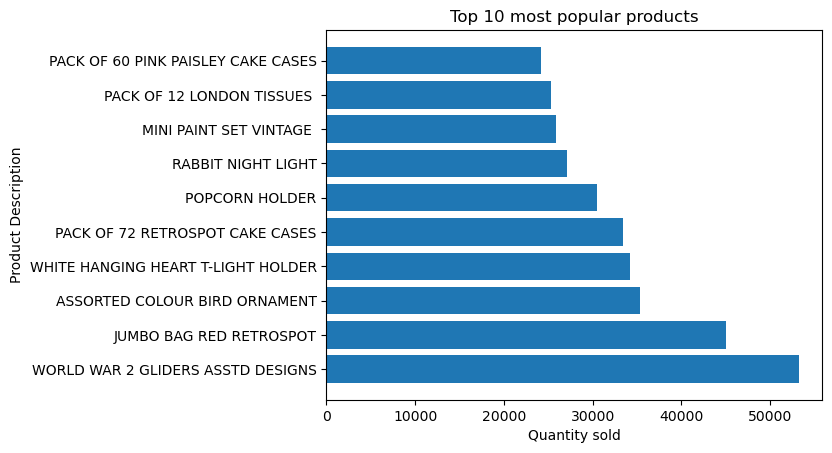

In [6]:
#EDA
# 1)Popular Products

popular_products=ret.groupby('Description')['Quantity'].sum().sort_values(ascending=False)[:10]

plt.barh(popular_products.index,popular_products.values)
plt.title('Top 10 most popular products')
plt.xlabel('Quantity sold')
plt.ylabel('Product Description')
plt.show()


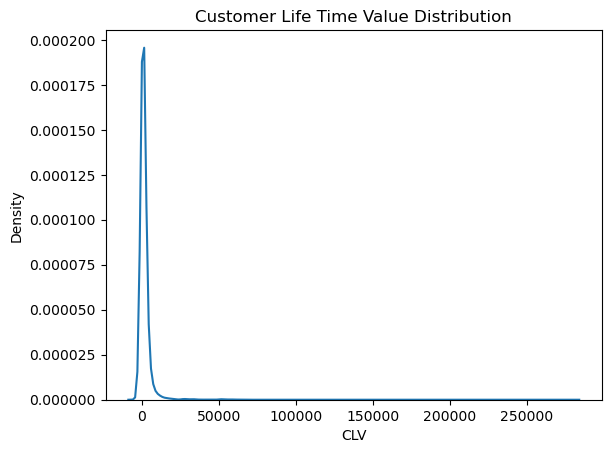

In [7]:
df=ret
df
df['Total_Sales']=ret['Quantity']*ret['UnitPrice']
clv=df.groupby('CustomerID')['Total_Sales'].sum()
# sns.histplot(clv,bins=50)
sns.kdeplot(clv)
plt.title('Customer Life Time Value Distribution')
plt.xlabel('CLV')
plt.ylabel('Density')
plt.show()


In [8]:
#Seasonal trends
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Month']=df['InvoiceDate'].dt.month
df['Year']=df['InvoiceDate'].dt.year

#Plot the monthly sales revenue over time
sales_by_month=df.groupby(['Year','Month'])['Quantity'].sum()

In [9]:
sales_by_month=sales_by_month.reset_index()
sales_by_month

,Year,Month,Quantity
0,2010,12,296362
1,2011,1,269379
2,2011,2,262833
3,2011,3,344012
4,2011,4,278585
5,2011,5,367852
6,2011,6,356922
7,2011,7,363418
8,2011,8,386612
9,2011,9,537496


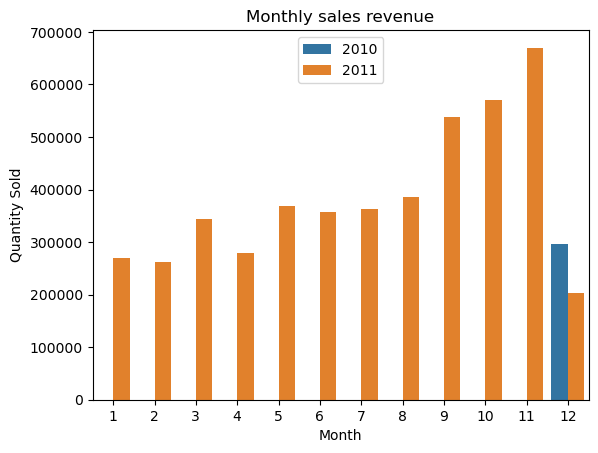

In [10]:
sns.barplot(x='Month',y='Quantity',hue='Year',data=sales_by_month)

plt.title('Monthly sales revenue')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.legend(loc='upper center')
plt.show()

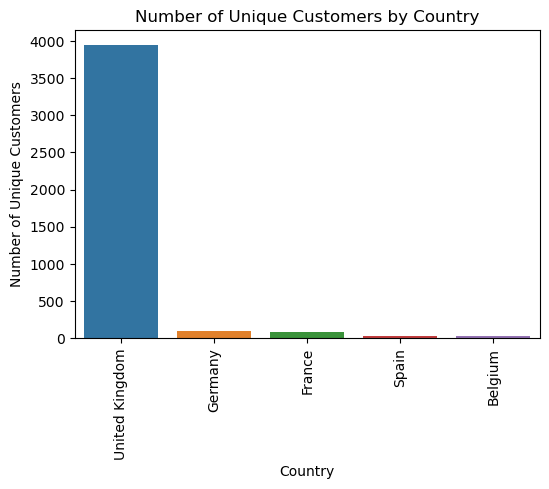

In [11]:
#Customer Demographics
plt.figure(figsize=(6,4))
customers_by_country=df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)[:5]
sns.barplot(x=customers_by_country.index,y=customers_by_country.values)
plt.title('Number of Unique Customers by Country')
plt.xlabel('Country')
plt.ylabel('Number of Unique Customers')
plt.xticks(rotation=90)
plt.show()

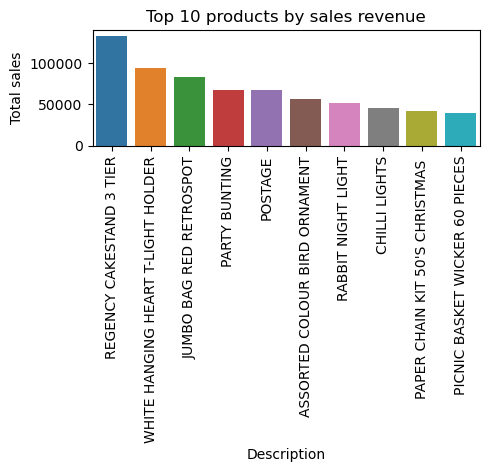

In [12]:
#Sales performance
plt.figure(figsize=(5,1.5))
df['Sales']=df['Quantity']*df['UnitPrice']
sales_by_product=df.groupby('Description')['Sales'].sum().sort_values(ascending=False)[:10]
sns.barplot(x=sales_by_product.index,y=sales_by_product.values)
plt.title('Top 10 products by sales revenue')
plt.xlabel('Description')
plt.xticks(rotation=90)
plt.ylabel('Total sales')
plt.show()

In [13]:
ret.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales,Month,Year,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,20.34


In [14]:
ret.shape

(406829, 12)

In [15]:
ret.describe()

,Quantity,UnitPrice,CustomerID,Total_Sales,Month,Year,Sales
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854,7.605947,2010.934002,20.401854
std,248.693370,69.315162,1713.600303,427.591718,3.418942,0.248279,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000,1.000000,2010.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000,5.000000,2011.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000,8.000000,2011.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000,11.000000,2011.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000,12.000000,2011.000000,168469.600000


In [16]:
retail=ret

Data Preparation We are going to analysis the Customers based on below 3 factors: R (Recency): Number of days since last purchase F (Frequency): Number of transactions M (Monetary): Total amount of transactions (revenue contributed)

In [17]:
#Attribute:Monetary
retail['Amount']=retail['Quantity']*retail['UnitPrice']

In [18]:
rfm_m=retail.groupby('CustomerID')['Amount'].sum()
rfm_m=rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [19]:
#Attribute:Frequency
rfm_f=retail.groupby('CustomerID')['InvoiceNo'].count()

rfm_f=rfm_f.reset_index()
rfm_f.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
#Merging the 2 dfs

rfm=pd.merge(rfm_m,rfm_f,on='CustomerID',how='inner')
rfm.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [21]:
#Attribute:Recency

retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'],format='%m/%d/%Y %H:%M')

In [22]:
#Computing the max adte to see the recency
max_date=max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [23]:
#Compute the difference between max date and transaction date
retail['Diff']=max_date-retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Sales,Month,Year,Sales,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010,15.30,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,20.34,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010,22.00,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,20.34,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,20.34,20.34,373 days 04:24:00


In [24]:
rfm_p=retail.groupby('CustomerID')['Diff'].min()
rfm_p=rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [25]:
rfm_p['Diff']=rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [26]:
rfm=pd.merge(rfm,rfm_p,on='CustomerID',how='inner')
rfm.columns=['CustomerID','Amount','Frequency','Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


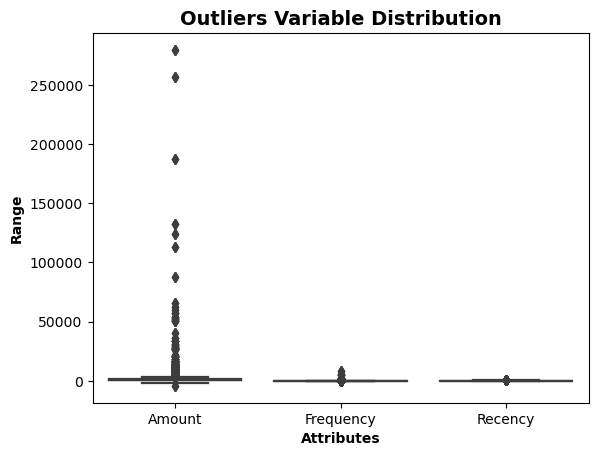

In [27]:
col_list=['Amount', 'Frequency', 'Recency']

for col in col_list:
    sns.boxplot(data = rfm[col_list], orient="v")
    plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')

In [28]:
#Removing statistical outliers 

Q1=rfm.Amount.quantile(0.05)
Q3=rfm.Amount.quantile(0.95)
IQR=Q3-Q1
rfm=rfm[(rfm.Amount>=Q1-1.5*IQR)&(rfm.Amount<=Q3+1.5*IQR)]

Q1=rfm.Recency.quantile(0.05)
Q3=rfm.Recency.quantile(0.95)
IQR=Q3-Q1
rfm=rfm[(rfm.Recency>=Q1-1.5*IQR)&(rfm.Recency<=Q3+1.5*IQR)]

Q1=rfm.Frequency.quantile(0.05)
Q3=rfm.Frequency.quantile(0.95)
IQR=Q3-Q1
rfm=rfm[(rfm.Frequency>=Q1-1.5*IQR)&(rfm.Frequency<=Q3+1.5*IQR)]

In [29]:
rfm.head()
#Customer ID can be removed
afr=rfm

In [30]:
afr["RecencyScore"] = pd.qcut(afr["Recency"], 5, labels = [5,4,3,2,1])
afr["RecencyScore"] = pd.qcut(afr["Recency"], 5, labels = [5,4,3,2,1])

afr["FrequencyScore"]= pd.qcut(afr["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
afr["FrequencyScore"]= pd.qcut(afr["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])

afr["MonetaryScore"] = pd.qcut(afr['Amount'], 5, labels = [1, 2, 3, 4, 5])
afr["MonetaryScore"] = pd.qcut(afr['Amount'], 5, labels = [1, 2, 3, 4, 5])

afr.head()

,CustomerID,Amount,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,0.00,2,325,1,1,1
1,12347.0,4310.00,182,1,5,5,5
2,12348.0,1797.24,31,74,2,3,4
3,12349.0,1757.55,73,18,4,4,4
4,12350.0,334.40,17,309,1,2,2


Rescaling the Attributes
It is extremely important to rescale the variables so that they have a comparable scale.| There are two common ways of rescaling:

Min-Max scaling
Standardisation
Here, we will use Standardisation Scaling.

In [31]:
rfm_df=rfm[['Amount','Frequency','Recency']]
scalar=StandardScaler()

In [32]:
rfm_df_scaled=scalar.fit_transform(rfm_df)
rfm_df_scaled.shape
rfm_df_scaled

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [33]:
rfm_df_scaled=pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns=['Amount','Frequency','Recency']

Step-4 Build the Model

K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.

The algorithm works as follows:

First we initialize k points, called means, randomly. We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far. We repeat the process for a given number of iterations and at the end, we have our clusters.

In [34]:
#K means with some arbitrary K
kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [35]:
kmeans.labels_

array([2, 3, 0, ..., 2, 0, 0])

Finding the Optimal Number of Clusters
Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

# Elbow-curve/SSD

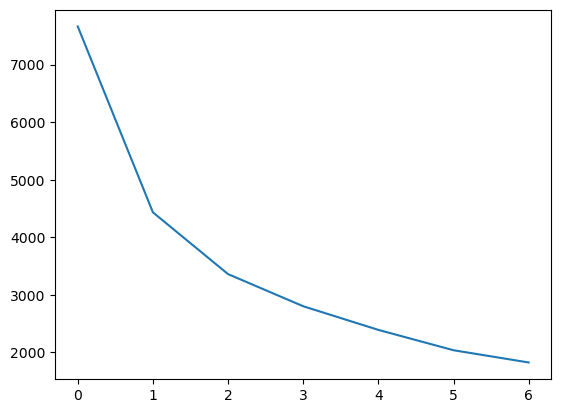

In [36]:
wcss=[]
range_n_clusters=[2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(wcss)

Silhouette Analysis
silhouette score=p−q/max(p,q)
 
p is the intra cluster distance
q is the inter cluster distance

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [37]:
#Silhouette Analysis

range_n_clusters=[2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels=kmeans.labels_
    silhouette_avg=silhouette_score(rfm_df_scaled,cluster_labels)
    print("For n_clusters={0},the silhouette score is {1}".format(num_clusters,silhouette_avg))
    

For n_clusters=2,the silhouette score is 0.5415858652525395
For n_clusters=3,the silhouette score is 0.5084896296141937
For n_clusters=4,the silhouette score is 0.48185520134959714
For n_clusters=5,the silhouette score is 0.464902620438719
For n_clusters=6,the silhouette score is 0.41698971636412085
For n_clusters=7,the silhouette score is 0.4172512757727203
For n_clusters=8,the silhouette score is 0.39439948764516547


In [38]:
#Finalising the model with k =3
kmeans=KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [39]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [40]:
rfm.head()

,CustomerID,Amount,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,0.00,2,325,1,1,1
1,12347.0,4310.00,182,1,5,5,5
2,12348.0,1797.24,31,74,2,3,4
3,12349.0,1757.55,73,18,4,4,4
4,12350.0,334.40,17,309,1,2,2


In [41]:
rfm['Cluster_ID']=kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore,Cluster_ID
0,12346.0,0.00,2,325,1,1,1,2
1,12347.0,4310.00,182,1,5,5,5,1
2,12348.0,1797.24,31,74,2,3,4,0
3,12349.0,1757.55,73,18,4,4,4,0
4,12350.0,334.40,17,309,1,2,2,2


In [42]:
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) + 
                     rfm['FrequencyScore'].astype(str) + 
                     rfm['MonetaryScore'].astype(str))
rfm.head()

,CustomerID,Amount,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore,Cluster_ID,RFM_SCORE
0,12346.0,0.00,2,325,1,1,1,2,111
1,12347.0,4310.00,182,1,5,5,5,1,555
2,12348.0,1797.24,31,74,2,3,4,0,234
3,12349.0,1757.55,73,18,4,4,4,0,444
4,12350.0,334.40,17,309,1,2,2,2,122


In [43]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,CustomerID,Amount,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore,Cluster_ID,RFM_SCORE,Segment
0,12346.0,0.00,2,325,1,1,1,2,111,Hibernating
1,12347.0,4310.00,182,1,5,5,5,1,555,Champions
2,12348.0,1797.24,31,74,2,3,4,0,234,At Risk
3,12349.0,1757.55,73,18,4,4,4,0,444,Loyal Customers
4,12350.0,334.40,17,309,1,2,2,2,122,Hibernating


In [44]:
rfm.Segment.value_counts()

Hibernating            1034
Loyal Customers         820
Champions               585
At Risk                 584
Potential Loyalists     511
About to Sleep          317
Need Attention          197
Promising               101
Can't Loose              88
New Customers            56
Name: Segment, dtype: int64

In [45]:
rfmStats = rfm[["Segment","Recency","Frequency","Amount"]].groupby("Segment").agg(["mean","median","count", "std"])
rfmStats.columns = rfmStats.columns.map('_'.join).str.strip('|')
rfmStats

,Recency_mean,Recency_median,Recency_count,Recency_std,Frequency_mean,Frequency_median,Frequency_count,Frequency_std,Amount_mean,Amount_median,Amount_count,Amount_std
Segment,,,,,,,,,,,,
About to Sleep,52.678233,52.0,317,11.079571,15.432177,15.0,317,7.815068,437.322524,301.320,317,682.161658
At Risk,167.164384,147.5,584,83.243801,54.895548,48.5,584,22.475167,927.632226,674.605,584,987.502143
Can't Loose,141.227273,121.0,88,67.866456,177.886364,155.0,88,71.969571,2249.420920,1967.300,88,1656.531847
Champions,4.895726,4.0,585,3.570388,200.405128,152.0,585,141.938831,3121.254444,2312.800,585,2599.386815
Hibernating,213.162476,213.0,1034,89.452095,13.088975,12.0,1034,8.003618,336.680911,245.990,1034,519.316497
Loyal Customers,32.871951,29.0,820,15.897856,150.024390,115.0,820,102.372393,2160.677744,1571.320,820,1918.094110
Need Attention,51.492386,52.0,197,11.177428,40.543147,39.0,197,8.041627,811.829391,654.920,197,1004.858511
New Customers,5.714286,6.5,56,3.323275,7.303571,7.5,56,3.813467,689.115357,204.000,56,1904.660354
Potential Loyalists,14.929550,15.0,511,9.532346,33.551859,33.0,511,12.302110,763.699004,570.400,511,862.980975


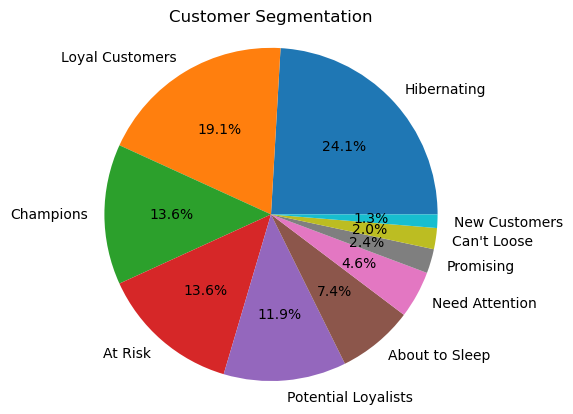

In [46]:
segment_counts = rfm['Segment'].value_counts()

# Create a pie chart
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%')
plt.title('Customer Segmentation')
plt.axis('equal') 
plt.show()

<AxesSubplot:xlabel='Cluster_ID', ylabel='Frequency'>

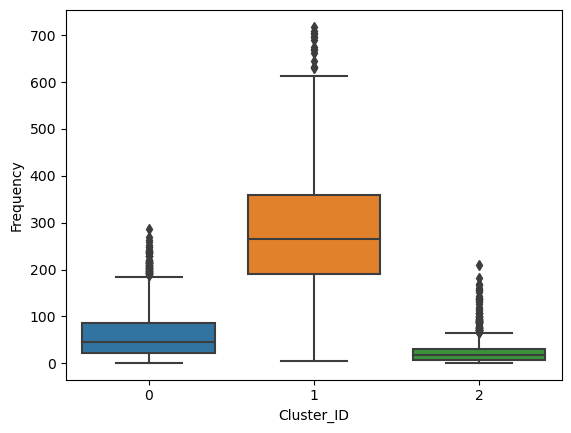

In [47]:

#Box plot to visualize ClusterID vs Frequency
sns.boxplot(x='Cluster_ID',y='Frequency',data=rfm)

<AxesSubplot:xlabel='Cluster_ID', ylabel='Recency'>

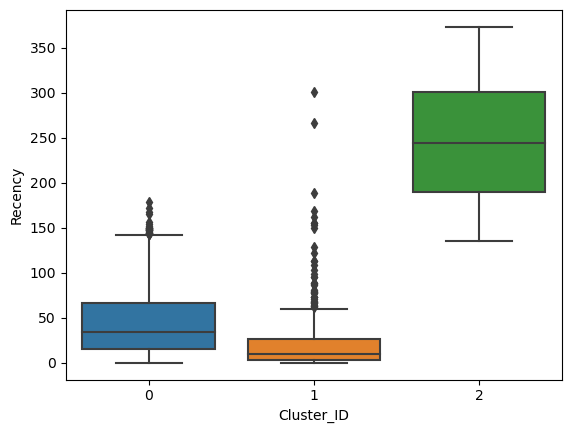

In [48]:
#Box plot to visualize ClusterID vs Recency
sns.boxplot(x='Cluster_ID',y='Recency',data=rfm)

<AxesSubplot:xlabel='Cluster_ID', ylabel='Amount'>

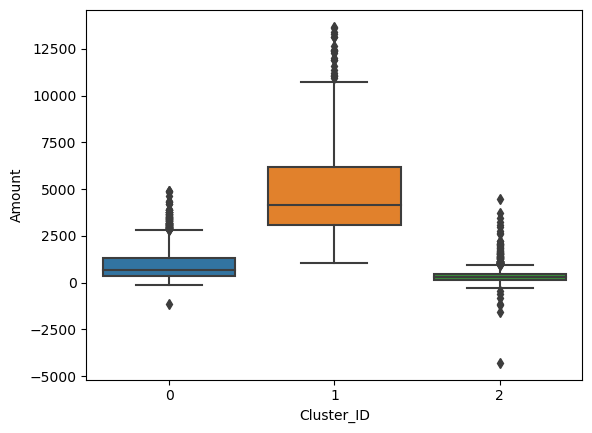

In [49]:
#Box plot to visualize ClusterID vs Amount
sns.boxplot(x='Cluster_ID',y='Amount',data=rfm)

Inference: K-Means Clustering with 3 Cluster Ids

Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers. Customers with Cluster Id 1 are frequent buyers. Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view. Hierarchical Clustering with 3 Cluster Labels

Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers. Customers with Cluster_Labels 2 are frequent buyers. Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.

Hierarchical Clustering
Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom.
For example, all files and folders on the hard disk are organized in a hierarchy.
There are two types of hierarchical clustering,

Divisive
Agglomerative.
Single Linkage:

In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance 
between two points in each cluster.


Linkage methods play a crucial role in hierarchical clustering by defining the distance between clusters. The distance between clusters is used to determine which clusters to merge at each iteration of the algorithm.

Different linkage methods can produce different dendrograms, and the choice of linkage method depends on the nature of the data and the research question.

Single linkage tends to produce long, branching dendrograms with small, compact clusters. It is particularly useful for identifying outliers and detecting small, densely packed clusters.

Complete linkage tends to produce compact, spherical clusters and is robust to outliers. It can be particularly useful for identifying well-separated clusters.

Average linkage is a compromise between single and complete linkage and can be a good choice when the data has a mix of small and large clusters.

Other linkage methods, such as Ward's method, focus on minimizing the variance within clusters and can be effective when the goal is to identify homogeneous clusters with low within-cluster variance.

In summary, the choice of linkage method can affect the shape of the dendrogram and the resulting clusters, so it's important to consider the characteristics of the data and the research question when choosing a linkage method.

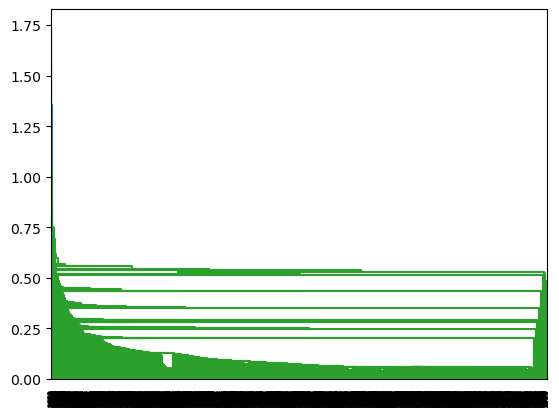

In [50]:
#Single linkage
mergings=linkage(rfm_df_scaled,method='single',metric='euclidean')
dendrogram(mergings)
plt.show()


Complete Linkage

In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster.

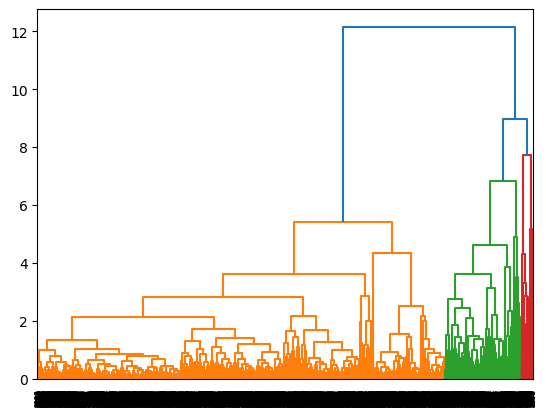

In [51]:
mergings=linkage(rfm_df_scaled,method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

Average Linkage:

In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.

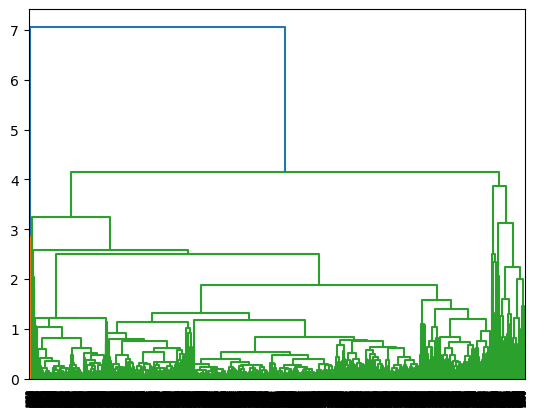

In [52]:
mergings=linkage(rfm_df_scaled,method='average',metric='euclidean')
dendrogram(mergings)
plt.show()

In [53]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore,Cluster_ID,RFM_SCORE,Segment,Cluster_Labels
0,12346.0,0.00,2,325,1,1,1,2,111,Hibernating,0
1,12347.0,4310.00,182,1,5,5,5,1,555,Champions,0
2,12348.0,1797.24,31,74,2,3,4,0,234,At Risk,0
3,12349.0,1757.55,73,18,4,4,4,0,444,Loyal Customers,0
4,12350.0,334.40,17,309,1,2,2,2,122,Hibernating,0


<AxesSubplot:xlabel='Cluster_Labels', ylabel='Amount'>

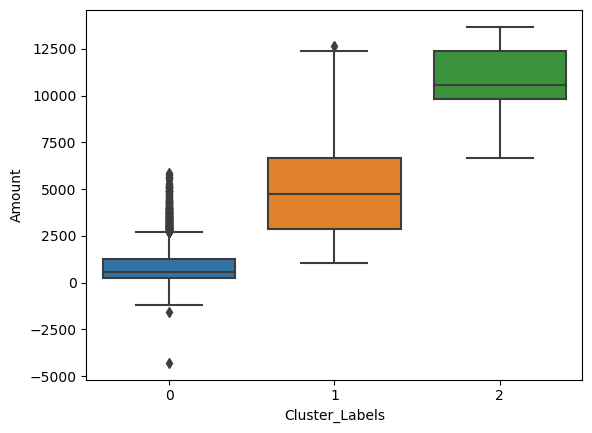

In [55]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

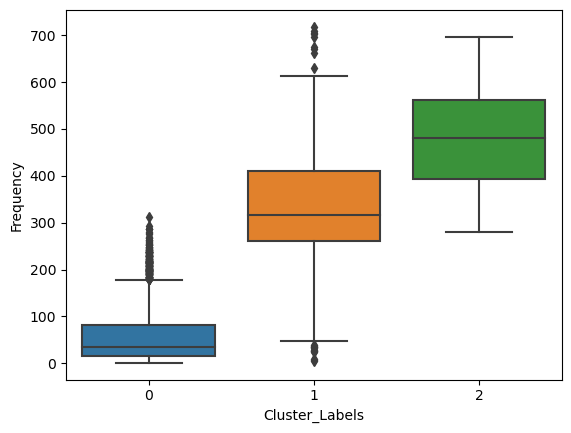

In [56]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

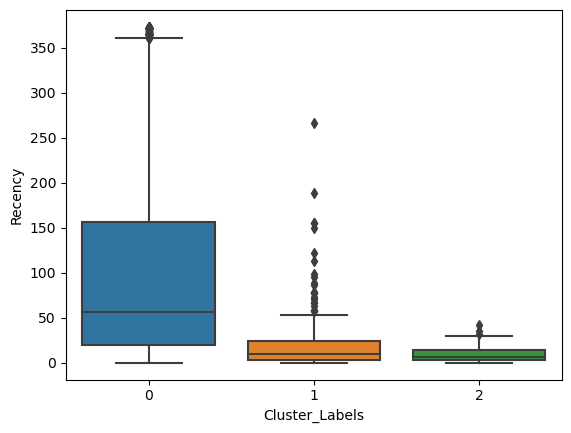

In [57]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

Inference:
K-Means Clustering with 3 Cluster Ids

Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
Customers with Cluster Id 1 are frequent buyers.
Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.
Hierarchical Clustering with 3 Cluster Labels

Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
Customers with Cluster_Labels 2 are frequent buyers.
Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.